In [208]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import pandas as pd
import math
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error as mse
import os
 
import physt
from physt import h1, h2, histogramdd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.signal import savgol_filter
from scipy.stats import gaussian_kde
import matplotlib as mpl

In [22]:
def hampel(vals_orig, k=10, t0=3):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''

    #Make copy so original not edited
    vals_orig = pd.Series(vals_orig[:,0])
    vals = vals_orig.copy()

    #Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)

    '''
    Perhaps a condition should be added here in the case that the threshold value
    is 0.0; maybe do not mark as outlier. MAD may be 0.0 without the original values
    being equal. See differences between MAD vs SDV.
    '''

    outlier_idx = difference > threshold
    vals[outlier_idx] = np.nan
    return(vals)

In [16]:
def normalize(quant, minn, maxx):
    a = -1
    b = 1
    t = a + ( quant - minn) * ((b - a) / (maxx - minn))
    return t.astype(np.float32)

In [62]:
lm10 = sio.loadmat('../../datasets/RawData/OFVC4kW_LM45Hz_TorqueSteps_20190419_Data.mat')

ValueError: x and y must have same first dimension, but have shapes (51366, 1) and (71901,)

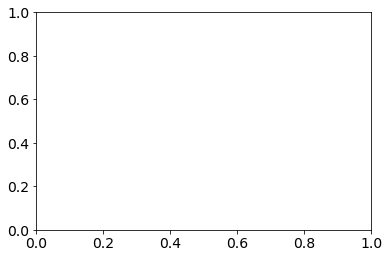

In [61]:
plt.plot(lm10['Time_I'],current1, label='Id', color='#3a7bd1', alpha=0.7)
plt.plot(lm10['Time_I'],current2, label='Iq', color='#bc4e38', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/lm10_current.pdf', dpi=500, format='pdf', pad_inches=0)

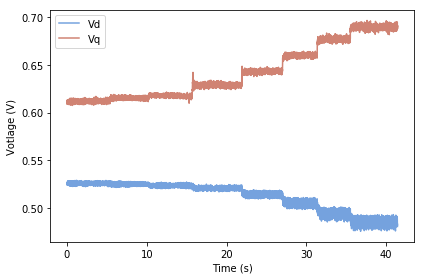

In [7]:
plt.plot(lm10['Time_VSpdTq'],voltage1, label='Vd', color='#3a7bd1', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'],voltage2, label='Vq', color='#bc4e38', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Votlage (V)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/lm10_votlage.pdf', dpi=500, format='pdf', pad_inches=0)

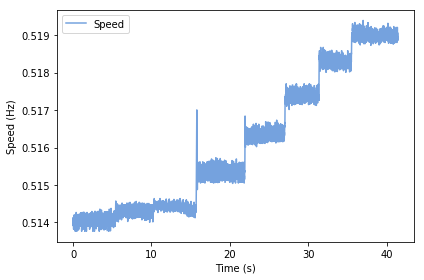

In [8]:
plt.plot(lm10['Time_VSpdTq'],speed, label='Speed', color='#3a7bd1', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Speed (Hz)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/lm10_speed.pdf', dpi=500, format='pdf', pad_inches=0)

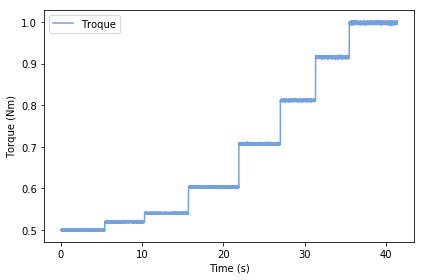

In [9]:
plt.plot(lm10['Time_VSpdTq'],torque, label='Troque', color='#3a7bd1', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/lm10_torque.pdf', dpi=500, format='pdf', pad_inches=0)

In [63]:
voltage1_r = normalize(hampel(lm10['VdRef_V']), -200, 200)
voltage2_r = normalize(hampel(lm10['VqRef_V']), -500, 500)
speed_r = normalize(hampel(lm10['Speed_Hz']) * 2 * math.pi, -700, 700)
current1_r = normalize(hampel(lm10['IdMeas_A']), -20, 20)
current2_r = normalize(hampel(lm10['IqMeas_A']), -30, 30)
torque_r = normalize(hampel(lm10['Torque_PercTnom']) / 100 * 25, -70, 70)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  from ipykernel import kernelapp as app


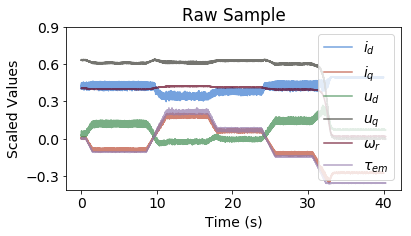

In [76]:
s = 0
e = 10000
plt.figure(figsize=(6,3))
plt.plot(lm10['Time_I'][s:e],current1_r[s:e], label=r'$i_d$', color='#3a7bd1', alpha=0.7)
plt.plot(lm10['Time_I'][s:e],current2_r[s:e], label=r'$i_q$', color='#bc4e38', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],voltage1_r[s:e], label=r'$u_d$', color='#418C51', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],voltage2_r[s:e], label=r'$u_q$', color='#3A3B33', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],speed_r[s:e], label=r'$\omega_r$', color='#650521', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],torque_r[s:e], label=r'$\tau_{em}$', color='#947CAD', alpha=0.7)
plt.yticks(np.arange(-0.3,1,step=0.3))
# plt.xticks(np.arange(0.0,22.0,step=2.0))
plt.legend()
# plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Scaled Values')
plt.title('Raw Sample')
plt.savefig('../../docs/figures/lm45_torquesteps.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

In [534]:
Current = sio.loadmat('../../datasets/SimSynthData/DATACS2det.mat/Current.mat')
Voltage = sio.loadmat('../../datasets/SimSynthData/DATACS2det.mat/Voltage.mat')
Time = sio.loadmat('../../datasets/SimSynthData/DATACS2det.mat/Time.mat')
Speed = sio.loadmat('../../datasets/SimSynthData/DATACS2det.mat/Speed.mat')
Torque = sio.loadmat('../../datasets/SimSynthData/DATACS2det.mat/Torque.mat')

In [26]:
voltage1 = normalize(Voltage['voltage'][:, 0], -200, 200)
voltage2 = normalize(Voltage['voltage'][: ,1], -500, 500)
speed = normalize(Speed['speed'][:, 0], -700, 700)
current1 = normalize(Current['current'][:, 0], -20, 20)
current2 = normalize(Current['current'][:, 1], -30, 30)
torque = normalize(Torque['torque'][:, 0], -70, 70)

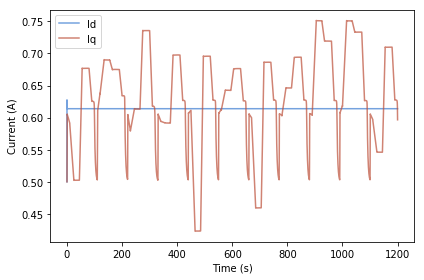

In [15]:
plt.plot(Time['time'],current1, label='Id', color='#3a7bd1', alpha=0.7)
plt.plot(Time['time'],current2, label='Iq', color='#bc4e38', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/sim_current_100.pdf', dpi=500, format='pdf', pad_inches=0)

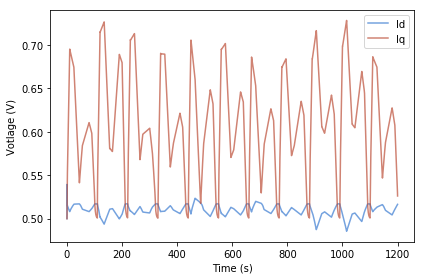

In [17]:
plt.plot(Time['time'],voltage1, label='Id', color='#3a7bd1', alpha=0.7)
plt.plot(Time['time'],voltage2, label='Iq', color='#bc4e38', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Votlage (V)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/sim_voltage.pdf', dpi=500, format='pdf', pad_inches=0)

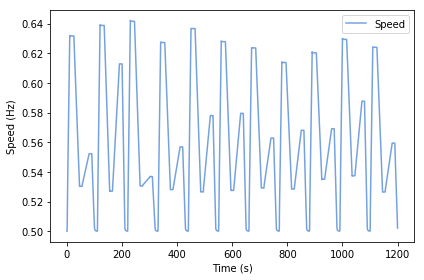

In [18]:
plt.plot(Time['time'],speed, label='Speed', color='#3a7bd1', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Speed (Hz)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/sim_speed.pdf', dpi=500, format='pdf', pad_inches=0)

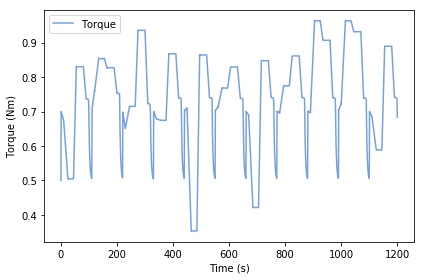

In [19]:
plt.plot(Time['time'],torque, label='Torque', color='#3a7bd1', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/sim_torque.pdf', dpi=500, format='pdf', pad_inches=0)

In [ ]:
Current = sio.loadmat('../../datasets/test_simulink/CS2018_12_14/Current.mat')
Time = sio.loadmat('../../datasets/test_simulink/CS2018_12_14/Time.mat')
Torque = sio.loadmat('../../datasets/test_simulink/CS2018_12_14/Torque.mat')
Voltage = sio.loadmat('../../datasets/test_simulink/CS2018_12_14/Voltage.mat')
Speed = sio.loadmat('../../datasets/test_simulink/CS2018_12_14/Speed.mat')

In [546]:
voltage1 = normalize(Voltage['Voltage'][:, 0], -200, 200)
voltage2 = normalize(Voltage['Voltage'][: ,1], -500, 500)
speed = normalize(Speed['Speed'][:, 0], -700, 700)
current1 = normalize(Current['Current'][:, 0], -20, 20)
current2 = normalize(Current['Current'][:, 1], -30, 30)
torque = normalize(Torque['Torque'][:, 0], -70, 70)
time = Time['t'][:, 0]

KeyError: 'Voltage'

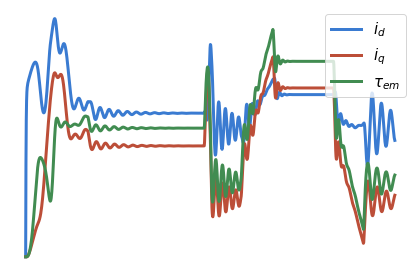

In [530]:
plt.plot(current1[:1200], label=r'$i_d$', color='#3a7bd1', linewidth=3)
plt.plot(current2[:1200], label=r'$i_q$', color='#bc4e38', linewidth=3)
plt.plot(torque[:1200], label=r'$\tau_{em}$', color='#418C51', linewidth=3)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/out.png', dpi=500, format='png', pad_inches=0, quality=100, transparent=True)

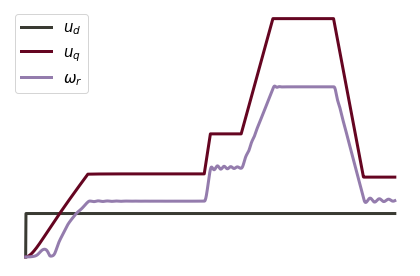

In [531]:
plt.plot(voltage1[:1200], label=r'$u_d$', color='#3A3B33', linewidth=3)
plt.plot(voltage2[:1200], label=r'$u_q$', color='#650521', linewidth=3)
plt.plot(speed[:1200], label=r'$\omega_r$', color='#947CAD', linewidth=3)
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.legend(loc='upper left', fontsize=15)
plt.tight_layout()
plt.savefig('../../docs/ICML/figures/inp.png', dpi=500, format='png', pad_inches=0, quality=100, transparent=True)

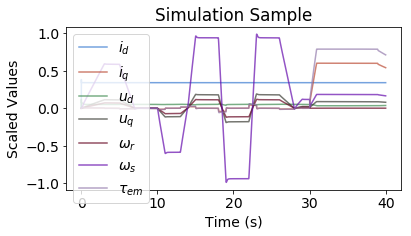

In [74]:
Current = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/Current.mat')
Time = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/Time.mat')
Torque = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/Torque.mat')
Voltage = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/Voltage.mat')
Speed = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/Speed.mat')
StatorPuls = sio.loadmat('../../datasets/SimSynthData/Data8Feb2019.mat/StatorPuls.mat')
voltage1 = normalize(Voltage['voltage'][:, 0], -200, 200)
voltage2 = normalize(Voltage['voltage'][: ,1], -500, 500)
speed = normalize(Speed['speed'][:, 0], -700, 700)
statorPuls = normalize(StatorPuls['statorPuls'][:,0], -85, 85)
current1 = normalize(Current['current'][:, 0], -20, 20)
current2 = normalize(Current['current'][:, 1], -30, 30)
torque = normalize(Torque['torque'][:, 0], -70, 70)
time = Time['time'][:, 0]
s = 0
e = 8000
plt.figure(figsize=(6,3))
plt.plot(Time['time'][s:e],current1[s:e], label=r'$i_d$', color='#3a7bd1', alpha=0.7)
plt.plot(Time['time'][s:e],current2[s:e], label=r'$i_q$', color='#bc4e38', alpha=0.7)
plt.plot(Time['time'][s:e],voltage1[s:e], label=r'$u_d$', color='#418C51', alpha=0.7)
plt.plot(Time['time'][s:e],voltage2[s:e], label=r'$u_q$', color='#3A3B33', alpha=0.7)
plt.plot(Time['time'][s:e],speed[s:e], label=r'$\omega_r$', color='#650521', alpha=0.7)
plt.plot(Time['time'][s:e],statorPuls[s:e], label=r'$\omega_s$', color='#650CAD', alpha=0.7)
plt.plot(Time['time'][s:e],torque[s:e], label=r'$\tau_{em}$', color='#947CAD', alpha=0.7)
plt.yticks(np.arange(-1,1.2,step=0.5))
# plt.xticks(np.arange(0.0,22.0,step=2.0))
plt.legend(loc=2)
# plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Scaled Values')
plt.title('Simulation Sample')
plt.savefig('../../docs/figures/sim.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

In [50]:
Stator_puls['statorPuls'].min()

-84.15763465905411

In [111]:
# torque = [0 for x in range(int(5/0.005))] + [5 for x in range(int(5/0.005))] + [10 for x in range(int(5/0.005))] + [25 for x in range(int(5/0.005))] + [50 for x in range(int(5/0.005))] + [75 for x in range(int(5/0.005))] + [100 for x in range(int(5/0.005))] + [120 for x in range(int(5/0.005))]
torque = [5 for x in range(int(40/0.005))]
# torque = np.asarray(torque) / 100 * 25
# speed = [68 for x in range(int(40/0.005))] 
speed = [0 for x in range(int(4/0.005))]  
speed += [1 for x in range(int(4/0.005))]
speed += [3 for x in range(int(4/0.005))]
speed += [5 for x in range(int(4/0.005))]
speed += [10 for x in range(int(4/0.005))]
speed += [20 for x in range(int(4/0.005))]
speed += [30 for x in range(int(4/0.005))]
speed += [40 for x in range(int(3/0.005))]
speed += [50 for x in range(int(3/0.005))]
speed += [75 for x in range(int(3/0.005))]
speed += [100 for x in range(int(3/0.005))]

print (len(speed),len(torque))
speed = np.asarray(speed) * 2 * math.pi
time = []

for x in range(len(speed)):
    time.append(x * 0.005)

8000 8000


In [112]:
sio.savemat('../../datasets/RefSynthData/0-100Hz.mat',
            {'Speed':np.asarray(speed),
            't':np.asarray(time),
            'Kvalv':np.asarray(torque)})

In [40]:
Data8Feb = sio.loadmat('../../datasets/RefSynthData/Data8Feb2019.mat')
time = Data8Feb['t'][0]
speed = Data8Feb['Speed'][0]
torque = Data8Feb['Kvalv'][0]
print (time.shape)

(3596,)


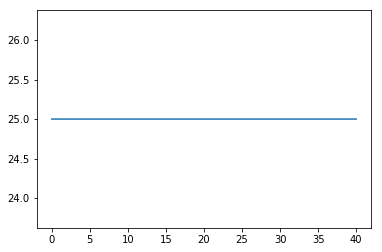

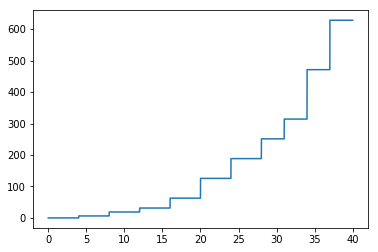

In [109]:
plt.plot(time, torque)
plt.show()
plt.plot(time, speed)
plt.show()

In [42]:
hampel(lm10['Torque_PercTnom'])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  from ipykernel import kernelapp as app


(10231,)

In [60]:
lm10['Speed_Hz'][0] * 2 * math.pi, lm10['Speed_Hz'][-1] * 2 * math.pi

(array([62.12622191]), array([83.26639464]))

In [78]:
lm10['Torque_PercTnom'][9200:9210]

array([[119.06738281],
       [119.87304688],
       [118.77441406],
       [118.53027344],
       [120.1171875 ],
       [119.36035156],
       [119.43359375],
       [120.33691406],
       [119.62890625],
       [119.75097656]])

In [29]:
data_raw = sio.loadmat('../../results_raw/LM20_TorqueSteps.mat')
data_sim = sio.loadmat('../../results_sim/LM20_TorqueSteps.mat')

In [30]:
data.keys()

dict_keys(['__globals__', '__version__', '__header__', 'Kvalv', 'Speed', 't'])

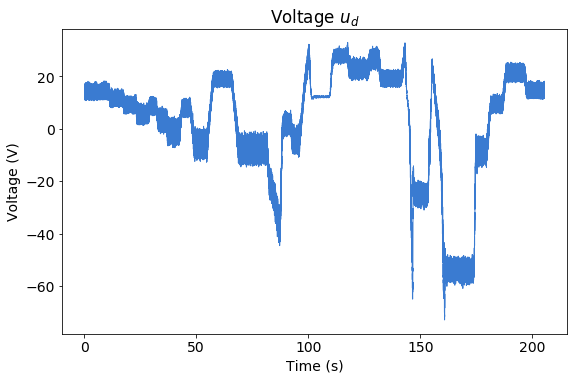

In [68]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
plt.plot(data_raw['time'][0,:],data_raw['voltage1'][0], label='Vd', color='#3a7bd1', linewidth=1)
# plt.legend()
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title(r'Voltage $u_d$')
plt.savefig('../../docs/figures/res_volt1.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

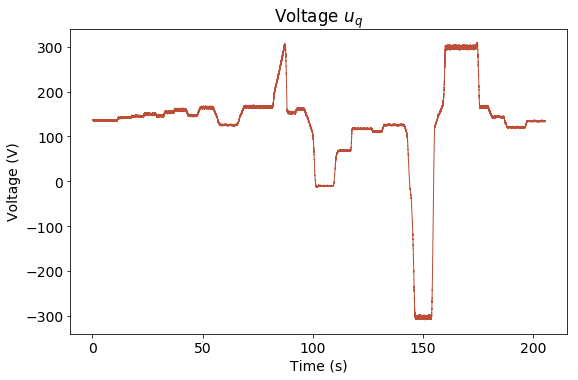

In [67]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
plt.plot(data_raw['time'][0,:],data_raw['voltage2'][0], label='Vq', color='#bc4e38', linewidth=1)
# plt.legend()
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title(r'Voltage $u_q$')
plt.savefig('../../docs/figures/res_volt2.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

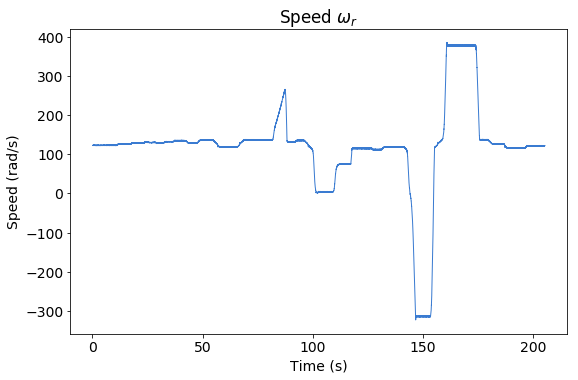

In [69]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
plt.plot(data_raw['time'][0,:],data_raw['speed'][0], color='#3a7bd1', linewidth=1)
# plt.legend()
plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.title(r'Speed $\omega_r$')
plt.savefig('../../docs/figures/res_speed.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

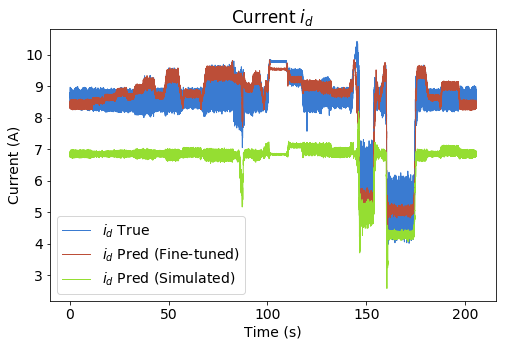

In [71]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
plt.plot(data_raw['time'][0,:],data_raw['current1_true'][0], label=r'$i_d$ True', color='#3a7bd1', linewidth=1)
plt.plot(data_raw['time'][0,:],data_raw['current1_pred'][0], label=r'$i_d$ Pred (Fine-tuned)', color='#bc4e38', linewidth=1)
plt.plot(data_sim['time'][0,:],data_sim['current1_pred'][0], label=r'$i_d$ Pred (Simulated)', color='#95DE32', linewidth=1)
plt.legend()
# plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title(r'Current $i_d$')
plt.savefig('../../docs/figures/res_sim_curr1.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

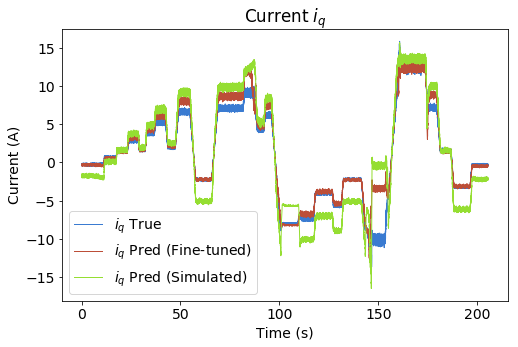

In [72]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
plt.plot(data_raw['time'][0,:],data_raw['current2_true'][0], label=r'$i_q$ True', color='#3a7bd1', linewidth=1)
plt.plot(data_raw['time'][0,:],data_raw['current2_pred'][0], label=r'$i_q$ Pred (Fine-tuned)', color='#bc4e38', linewidth=1)
plt.plot(data_sim['time'][0,:],data_sim['current2_pred'][0], label=r'$i_q$ Pred (Simulated)', color='#95DE32', linewidth=1)
plt.legend()
# plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title(r'Current $i_q$')
plt.savefig('../../docs/figures/res_sim_curr2.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

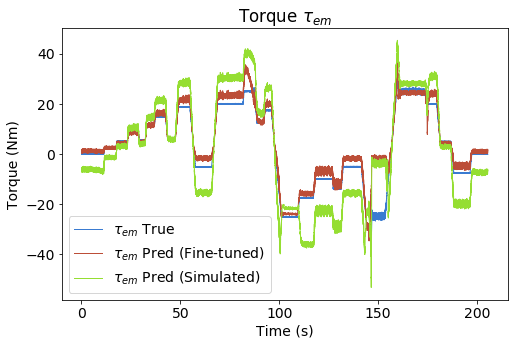

In [73]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
plt.plot(data_raw['time'][0,:],data_raw['torque_true'][0], label=r'$\tau_{em}$ True', color='#3a7bd1', linewidth=1)
plt.plot(data_raw['time'][0,:],data_raw['torque_pred'][0], label=r'$\tau_{em}$ Pred (Fine-tuned)', color='#bc4e38', linewidth=1)
plt.plot(data_sim['time'][0,:],data_sim['torque_pred'][0], label=r'$\tau_{em}$ Pred (Simulated)', color='#95DE32', linewidth=1)
plt.legend()
# plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title(r'Torque $\tau_{em}$')
plt.savefig('../../docs/figures/res_sim_torque.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

In [209]:
def sc(signal):
    return np.sum(abs(signal[1:] - signal[:-1]))

In [210]:
def smape(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / (np.abs(A) + np.abs(F)) / 2)

In [211]:
results = os.listdir('../../../results_raw/')

In [312]:
curr1_sc_mse_smape_raw = []
curr2_sc_mse_smape_raw = []
torque_sc_mse_smape_raw = []

curr1_sc_mse_smape_sim = []
curr2_sc_mse_smape_sim = []
torque_sc_mse_smape_sim = []


for result in results:
    if 'mat' in result:
        data_raw = sio.loadmat('../../../results_raw/' + result)
        data_sim = sio.loadmat('../../../results_sim/' + result)
        
        for i in range(0,data_raw['current1_true'].shape[1],1):
            if i+101 < data_raw['current1_true'].shape[1]:
                scv_raw = sc(data_raw['current1_true'][0,i:i+100])
                msev_raw = mse(data_raw['current1_true'][0,i:i+100],data_raw['current1_pred'][0,i:i+100])
                smape_raw = smape(data_raw['current1_true'][0,i:i+100],data_raw['current1_pred'][0,i:i+100])
                curr1_sc_mse_smape_raw.append([scv_raw,msev_raw,smape_raw])
                
                scv_sim = sc(data_sim['current1_true'][0,i:i+100])
                msev_sim = mse(data_sim['current1_true'][0,i:i+100],data_sim['current1_pred'][0,i:i+100])
                smape_sim = smape(data_sim['current1_true'][0,i:i+100],data_sim['current1_pred'][0,i:i+100])
                curr1_sc_mse_smape_sim.append([scv_sim,msev_sim,smape_sim])


        for i in range(0,data_raw['current2_true'].shape[1],1):
            if i+101 < data_raw['current2_true'].shape[1]: 
                scv_raw = sc(data_raw['current2_true'][0,i:i+100])
                msev_raw = mse(data_raw['current2_true'][0,i:i+100],data_raw['current2_pred'][0,i:i+100])
                smape_raw = smape(data_raw['current2_true'][0,i:i+100],data_raw['current2_pred'][0,i:i+100])
                curr2_sc_mse_smape_raw.append([scv_raw,msev_raw,smape_raw])
                
                scv_sim = sc(data_sim['current2_true'][0,i:i+100])
                msev_sim = mse(data_sim['current2_true'][0,i:i+100],data_sim['current2_pred'][0,i:i+100])
                smape_sim = smape(data_sim['current2_true'][0,i:i+100],data_sim['current2_pred'][0,i:i+100])
                curr2_sc_mse_smape_sim.append([scv_sim,msev_sim,smape_sim])

        for i in range(0,data_raw['torque_true'].shape[1],1):
            if i+101 < data_raw['torque_true'].shape[1]:
                scv_raw = sc(data_raw['torque_true'][0,i:i+100])
                msev_raw = mse(data_raw['torque_true'][0,i:i+100],data_raw['torque_pred'][0,i:i+100])
                smape_raw = smape(data_raw['torque_true'][0,i:i+100],data_raw['torque_pred'][0,i:i+100])
                torque_sc_mse_smape_raw.append([scv_raw,msev_raw,smape_raw])
                
                scv_sim = sc(data_sim['torque_true'][0,i:i+100])
                msev_sim = mse(data_sim['torque_true'][0,i:i+100],data_sim['torque_pred'][0,i:i+100])
                smape_sim = smape(data_sim['torque_true'][0,i:i+100],data_sim['torque_pred'][0,i:i+100])
                torque_sc_mse_smape_sim.append([scv_sim,msev_sim,smape_sim])

In [313]:
curr1_sc_mse_smape_raw = np.asarray(curr1_sc_mse_smape_raw)
curr2_sc_mse_smape_raw = np.asarray(curr2_sc_mse_smape_raw)
torque_sc_mse_smape_raw = np.asarray(torque_sc_mse_smape_raw)

curr1_sc_mse_smape_sim = np.asarray(curr1_sc_mse_smape_sim)
curr2_sc_mse_smape_sim = np.asarray(curr2_sc_mse_smape_sim)
torque_sc_mse_smape_sim = np.asarray(torque_sc_mse_smape_sim)

In [314]:
norm = mpl.colors.Normalize(vmin=0,vmax=1000)

In [315]:
curr1_sc_mse_smape_raw = np.sort(curr1_sc_mse_smape_raw, axis=0)
curr2_sc_mse_smape_raw = np.sort(curr2_sc_mse_smape_raw, axis=0)
torque_sc_mse_smape_raw = np.sort(torque_sc_mse_smape_raw, axis=0)

curr1_sc_mse_smape_sim = np.sort(curr1_sc_mse_smape_sim, axis=0)
curr2_sc_mse_smape_sim = np.sort(curr2_sc_mse_smape_sim, axis=0)
torque_sc_mse_smape_sim = np.sort(torque_sc_mse_smape_sim, axis=0)

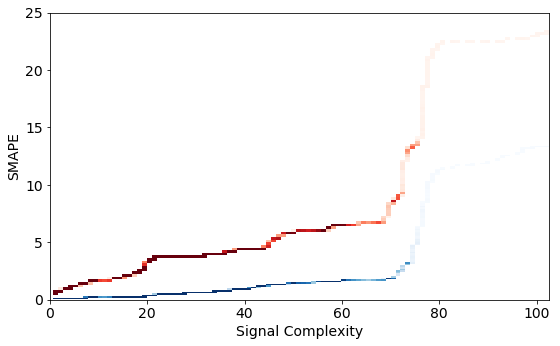

In [229]:
# plt.plot(curr1_sc_mse[:,0],curr1_sc_mse[:,1], marker='o', markersize=0.7)
# plt.legend()
# plt.tight_layout()
# plt.xlabel('Signal Complexity')
# plt.ylabel('MSE')
# plt.savefig('../../docs/ICML/figures/sc_mse_curr1.pdf', dpi=500, format='pdf', pad_inches=0)
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
ax = plt.axes()
h_2_raw = h2(curr1_sc_mse_smape_raw[:,0], curr1_sc_mse_smape_raw[:,2] / 2.5 , 100, label='Fine-tuned')
h_2_sim = h2(curr1_sc_mse_smape_sim[:,0], curr1_sc_mse_smape_sim[:,2] / 1.5, 100, label='Simulated')
rp = h_2_raw.plot("map", lw=0.0, alpha=1,  ax=ax, cmap="Blues",  show_zero=False, cmap_normalize=norm, show_colorbar=False)
sp = h_2_sim.plot("map", lw=0.0, alpha=1,  ax=ax, cmap="Reds",   show_zero=False, cmap_normalize=norm, show_colorbar=False)
# plt.plot(curr1_sc_mse_smape_raw[:,0], curr1_sc_mse_smape_raw[:,2], label='Raw')
# plt.plot(curr1_sc_mse_smape_sim[:,0], curr1_sc_mse_smape_sim[:,2], label='Simulated')
# plt.legend(['Raw','Simulated'])
# plt.tight_layout()
plt.xlabel('Signal Complexity')
plt.ylabel('SMAPE')
# plt.title(r'Current $i_d$')
plt.xticks(np.arange(0, 101, 20))
plt.yticks(np.arange(0, 25.1, 5))
# plt.show()
plt.savefig('sc_smape_curr1.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)
# plt.show()

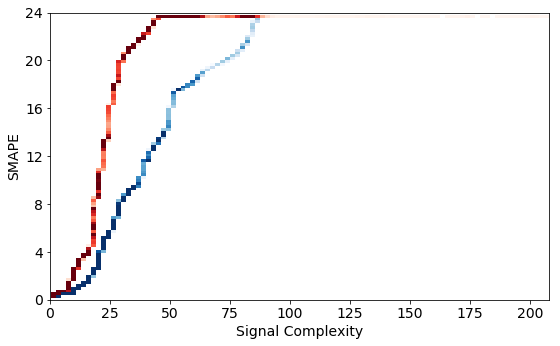

In [325]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
ax = plt.axes()
h_2_raw = h2(curr2_sc_mse_smape_raw[:,0], curr2_sc_mse_smape_raw[:,2]/2.1, 100)
h_2_raw.plot("map", lw=0.0, alpha=1, cmap="Blues", ax=ax, show_zero=False, cmap_normalize=norm, label='Fine-tuned', show_colorbar=False)
h_2_sim = h2(curr2_sc_mse_smape_sim[:,0], curr2_sc_mse_smape_sim[:,2]/2.1, 100)
h_2_sim.plot("map", lw=0.0, alpha=1, cmap="Reds", ax=ax,  show_zero=False, cmap_normalize=norm, label='Simulated', show_colorbar=False)
# plt.plot(curr2_sc_mse_raw[:,0], curr2_sc_mse_raw[:,1], label='Raw')
# plt.plot(curr2_sc_mse_sim[:,0], curr2_sc_mse_sim[:,1], label='Simulated')
# plt.legend()
# plt.tight_layout()
plt.xlabel('Signal Complexity')
plt.ylabel('SMAPE')
# plt.title(r'Current $i_q$')
plt.xticks(np.arange(0, 201, 25))
plt.yticks(np.arange(0, 24.1, 4))
plt.savefig('sc_smape_curr2.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

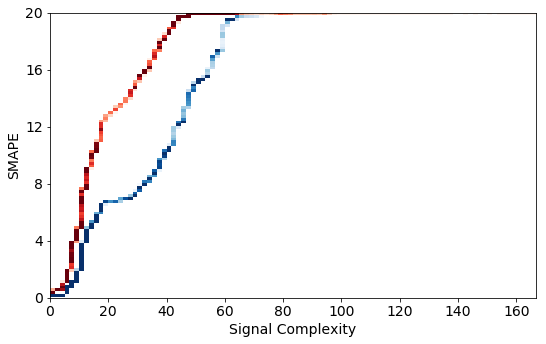

In [329]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
ax = plt.axes()
h_2_raw = h2(torque_sc_mse_smape_raw[:,0], torque_sc_mse_smape_raw[:,2]/2.5, 100)
h_2_raw.plot("map", lw=0.0, alpha=1, cmap="Blues", ax=ax, show_zero=False, cmap_normalize=norm, label='Fine-tuned', show_colorbar=False)
h_2_sim = h2(torque_sc_mse_smape_sim[:,0], torque_sc_mse_smape_sim[:,2]/2.5, 100)
h_2_sim.plot("map", lw=0.0, alpha=1, cmap="Reds", ax=ax,  show_zero=False, cmap_normalize=norm, label='Simulated', show_colorbar=False)
# plt.plot(torque_sc_mse_raw[:,0], torque_sc_mse_raw[:,1], label='Raw')
# plt.plot(torque_sc_mse_sim[:,0], torque_sc_mse_sim[:,1], label='Simulated')
# plt.legend()
# plt.tight_layout()
plt.xlabel('Signal Complexity')
plt.ylabel('SMAPE')
# plt.title(r'Torque $\tau_{em}$')
plt.xticks(np.arange(0, 161, 20))
plt.yticks(np.arange(0, 20.1, 4))
plt.savefig('sc_smape_torque.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

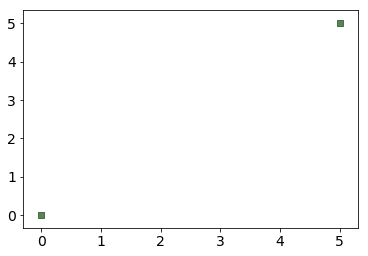

<Figure size 176.4x39.6 with 0 Axes>

In [332]:
import pylab
fig = pylab.figure()
figlegend = pylab.figure(figsize=(2.45,.55))
ax = fig.add_subplot(111)
line1 = ax.scatter([0,5], [0,5], color='Purple', marker="s", alpha=0.5)
line2 = ax.scatter([0,5], [0,5],  color='Green', marker="s", alpha=0.5)
plt.tight_layout()
figlegend.legend([line1,line2], ('MSE', 'TV-Normalised MSE'), 'center')

# fig.show()
# figlegend.show()
figlegend.savefig('tv_mse_legend.pdf',dpi=500,format='pdf',pad_inches=0)

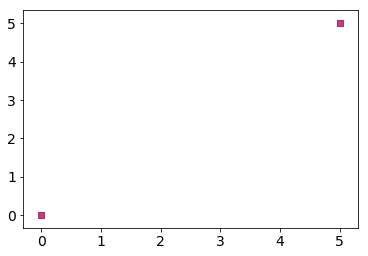

<Figure size 113.04x39.6 with 0 Axes>

In [342]:
import pylab
fig = pylab.figure()
figlegend = pylab.figure(figsize=(1.57,.55))
ax = fig.add_subplot(111)
line1 = ax.scatter([0,5], [0,5], color='Blue', marker="s", alpha=0.5)
line2 = ax.scatter([0,5], [0,5],  color='Red', marker="s", alpha=0.5)
plt.tight_layout()
figlegend.legend([line2, line1], ('Simulated', 'Fine-tuned'), 'center')

# fig.show()
# figlegend.show()
figlegend.savefig('legend.pdf',dpi=500,format='pdf',pad_inches=0)

In [467]:
ax.scatter

Signature: ax.plot(*args, scalex=True, scaley=True, data=None, **kwargs)
Docstring:
Plot y versus x as lines and/or markers.

Call signatures::

    plot([x], y, [fmt], data=None, **kwargs)
    plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)

The coordinates of the points or line nodes are given by *x*, *y*.

The optional parameter *fmt* is a convenient way for defining basic
formatting like color, marker and linestyle. It's a shortcut string
notation described in the *Notes* section below.

>>> plot(x, y)        # plot x and y using default line style and color
>>> plot(x, y, 'bo')  # plot x and y using blue circle markers
>>> plot(y)           # plot y using x as index array 0..N-1
>>> plot(y, 'r+')     # ditto, but with red plusses

You can use `.Line2D` properties as keyword arguments for more
control on the appearance. Line properties and *fmt* can be mixed.
The following two calls yield identical results:

>>> plot(x, y, 'go--', linewidth=2, markersize=12)
>>> plot(x, y, col

In [2]:
data = sio.loadmat('../../datasets/RefSynthData/Data8Feb2019.mat')

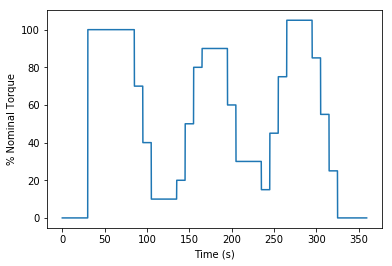

In [13]:
plt.plot(data['t'][0,:],data['Kvalv'][0,:])
plt.xlabel('Time (s)')
plt.ylabel('% Nominal Torque')
plt.savefig('../../docs/figures/torque_ref.png',dpi=1000, transparent=True)

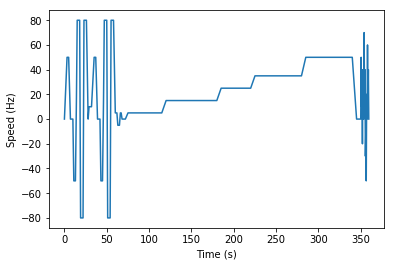

In [14]:
plt.plot(data['t'][0,:],data['Speed'][0,:])
plt.xlabel('Time (s)')
plt.ylabel('Speed (Hz)')
plt.savefig('../../docs/figures/speed_ref.png',dpi=1000, transparent=True)

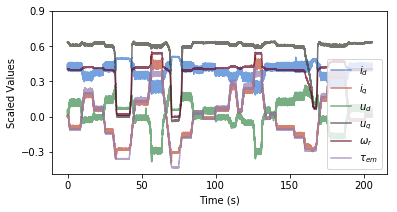

In [25]:
s = 0
e = -1
plt.figure(figsize=(6,3))
plt.plot(lm10['Time_I'][s:e],current1_r[s:e], label=r'$i_d$', color='#3a7bd1', alpha=0.7)
plt.plot(lm10['Time_I'][s:e],current2_r[s:e], label=r'$i_q$', color='#bc4e38', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],voltage1_r[s:e], label=r'$u_d$', color='#418C51', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],voltage2_r[s:e], label=r'$u_q$', color='#3A3B33', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],speed_r[s:e], label=r'$\omega_r$', color='#650521', alpha=0.7)
plt.plot(lm10['Time_VSpdTq'][s:e],torque_r[s:e], label=r'$\tau_{em}$', color='#947CAD', alpha=0.7)
plt.yticks(np.arange(-0.3,1,step=0.3))
# plt.xticks(np.arange(0.0,22.0,step=2.0))
plt.legend()
# plt.tight_layout()
plt.xlabel('Time (s)')
plt.ylabel('Scaled Values')
plt.savefig('../../docs/figures/lm45_torquesteps.png', dpi=500, pad_inches=0, bbox_inches = 'tight', transparent=True)

In [183]:
sc1 = list(np.random.uniform(1, 20, 100000))
sc2 = list(np.random.uniform(21, 50, 50000))
sc3 = list(np.random.uniform(51, 65, 25000))
sc4 = list(np.random.uniform(66, 72, 3000))
sc5 = list(np.random.uniform(73, 81, 3000))
sc6 = list(np.random.uniform(82, 88, 1000))
sc7 = list(np.random.uniform(89, 93, 1000))
sc8 = list(np.random.uniform(94, 99.5, 500))

smape1 = list(np.random.uniform(0, 2.5, 100000))
smape2 = list(np.random.uniform(2.5, 3.2, 50000))
smape3 = list(np.random.uniform(3.3, 4.7, 25000))
smape4 = list(np.random.uniform(4.8, 7, 3000))
smape5 = list(np.random.uniform(7.1, 9.8, 3000))
smape6 = list(np.random.uniform(9.9, 13, 1000))
smape7 = list(np.random.uniform(13.1, 17, 1000))
smape8 = list(np.random.uniform(17.1, 20.1, 500))

sc1.sort()
sc2.sort()
sc3.sort()
sc4.sort()
sc5.sort()
sc6.sort()
sc7.sort()
sc8.sort()
smape1.sort()
smape2.sort()
smape3.sort()
smape4.sort()
smape5.sort()
smape6.sort()
smape7.sort()
smape8.sort()

sc = sc1 + sc2 + sc3 + sc4 + sc5 + sc6 + sc7 + sc8
smape = smape1 + smape2 + smape3 + smape4 + smape5 + smape6 + smape7 + smape8


In [184]:
smape1 = list(np.random.uniform(0, 2.5/2, 100000))
smape2 = list(np.random.uniform(2.5/2, 3.2/2, 50000))
smape3 = list(np.random.uniform(3.3/2, 4.7/2, 25000))
smape4 = list(np.random.uniform(4.8/2, 7/2, 3000))
smape5 = list(np.random.uniform(7.1/2, 9.8/2, 3000))
smape6 = list(np.random.uniform(9.9/2, 13/2, 1000))
smape7 = list(np.random.uniform(13.1/2, 17/2, 1000))
smape8 = list(np.random.uniform(17.1/2, 15, 490))
smape9 = list(np.random.uniform(15.1, 20, 10))

smape1.sort()
smape2.sort()
smape3.sort()
smape4.sort()
smape5.sort()
smape6.sort()
smape7.sort()
smape8.sort()
smape9.sort()

smape_tv = smape1 + smape2 + smape3 + smape4 + smape5 + smape6 + smape7 + smape8 + smape9


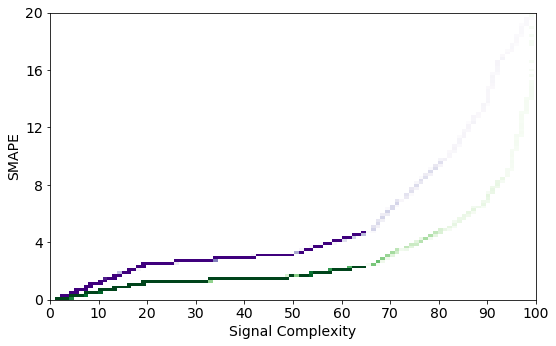

In [185]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
ax = plt.axes()
h_2_sim = h2(sc, smape_tv, 100, label='TV-Normalised MSE')
h_2_raw = h2(sc, smape, 100, label='MSE')

rp = h_2_raw.plot("map", lw=0.0, alpha=1,  ax=ax, cmap="Purples",  show_zero=False, cmap_normalize=norm, show_colorbar=False)
sp = h_2_sim.plot("map", lw=0.0, alpha=1,  ax=ax, cmap="Greens",   show_zero=False, cmap_normalize=norm, show_colorbar=False)
plt.xlabel('Signal Complexity')
plt.ylabel('SMAPE')
# plt.title(r'Current $i_d$')
plt.xticks(np.arange(0, 101, 10))
plt.yticks(np.arange(0, 20.1, 4))
plt.savefig('tv_vs_mse_sc_smape_curr1.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

In [186]:
sc1 = list(np.random.uniform(1, 20, 100000))
sc2 = list(np.random.uniform(21, 31, 25000))
sc3 = list(np.random.uniform(32, 42, 15000))
sc4 = list(np.random.uniform(43, 53, 15000))
sc5 = list(np.random.uniform(54, 66, 10000))
sc6 = list(np.random.uniform(67, 78, 10000))
sc7 = list(np.random.uniform(79, 90, 2000))
sc8 = list(np.random.uniform(91, 98, 2000))
sc9 = list(np.random.uniform(99, 108, 1000))
sc10 = list(np.random.uniform(109, 120, 1000))
sc11 = list(np.random.uniform(121, 130, 500))
sc12 = list(np.random.uniform(131, 140, 500))
sc13 = list(np.random.uniform(141, 168, 500))
sc14 = list(np.random.uniform(169, 180, 500))
sc15 = list(np.random.uniform(181, 200, 100))

smape1 = list(np.random.uniform(0, 3.1, 100000))
smape2 = list(np.random.uniform(3.2, 3.9, 25000))
smape3 = list(np.random.uniform(4.1, 4.9, 15000))
smape4 = list(np.random.uniform(5.1, 5.5, 15000))
smape5 = list(np.random.uniform(5.6, 6.6, 10000))
smape6 = list(np.random.uniform(6.6, 6.9, 10000))
smape7 = list(np.random.uniform(7.0, 7.9, 2000))
smape8 = list(np.random.uniform(8.1, 8.7, 2000))
smape9 = list(np.random.uniform(8.8, 11.3, 1000))
smape10 = list(np.random.uniform(11.4, 14.6, 1000))
smape11 = list(np.random.uniform(14.7, 19.7, 500))
smape12 = list(np.random.uniform(19.8, 23, 500))
smape13 = list(np.random.uniform(23.1, 24.5, 500))
smape14 = list(np.random.uniform(24.6, 25.6, 500))
smape15 = list(np.random.uniform(25.7, 28, 100))

sc1.sort()
sc2.sort()
sc3.sort()
sc4.sort()
sc5.sort()
sc6.sort()
sc7.sort()
sc8.sort()
sc9.sort()
sc10.sort()
sc11.sort()
sc12.sort()
sc13.sort()
sc14.sort()
sc15.sort()
smape1.sort()
smape2.sort()
smape3.sort()
smape4.sort()
smape5.sort()
smape6.sort()
smape7.sort()
smape8.sort()
smape9.sort()
smape10.sort()
smape11.sort()
smape12.sort()
smape13.sort()
smape14.sort()
smape15.sort()

sc = sc1 + sc2 + sc3 + sc4 + sc5 + sc6 + sc7 + sc8 + sc9 + sc10 + sc11 + sc12 + sc13 + sc14 + sc15
smape = smape1 + smape2 + smape3 + smape4 + smape5 + smape6 + smape7 + smape8 + smape9 + smape10 + smape11 + smape12 + smape13 + smape14 + smape15

smape1 = list(np.random.uniform(0/2, 3.1/2.5, 100000))
smape2 = list(np.random.uniform(3.2/2.5, 3.9/2, 25000))
smape3 = list(np.random.uniform(4.1/2, 4.9/2, 15000))
smape4 = list(np.random.uniform(5.1/2, 5.5/2.5, 15000))
smape5 = list(np.random.uniform(5.6/2.5, 6.6/2, 10000))
smape6 = list(np.random.uniform(6.6/2, 6.9/2, 10000))
smape7 = list(np.random.uniform(7.0/2, 7.9/2, 2000))
smape8 = list(np.random.uniform(8.1/2, 8.7/2, 2000))
smape9 = list(np.random.uniform(8.8/2, 11.3/2, 1000))
smape10 = list(np.random.uniform(11.4/2, 14.6/2, 1000))
smape11 = list(np.random.uniform(14.7/2, 19.7/2, 500))
smape12 = list(np.random.uniform(19.8/2, 23/2, 500))
smape13 = list(np.random.uniform(23.1/2, 24.5/2, 500))
smape14 = list(np.random.uniform(24.6/2, 25.6/2.0, 500))
smape15 = list(np.random.uniform(25.7/2.0, 28, 100))

smape1.sort()
smape2.sort()
smape3.sort()
smape4.sort()
smape5.sort()
smape6.sort()
smape7.sort()
smape8.sort()
smape9.sort()
smape10.sort()
smape11.sort()
smape12.sort()
smape13.sort()
smape14.sort()
smape15.sort()

smape_tv = smape1 + smape2 + smape3 + smape4 + smape5 + smape6 + smape7 + smape8 + smape9 + smape10 + smape11 + smape12 + smape13 + smape14 + smape15



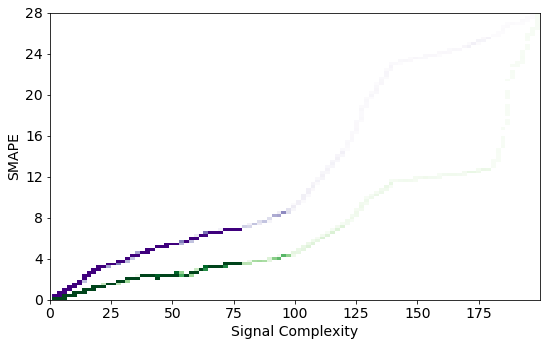

In [187]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
ax = plt.axes()
h_2_sim = h2(sc, smape_tv, 100, label='TV-Normalised MSE')
h_2_raw = h2(sc, smape, 100, label='MSE')

rp = h_2_raw.plot("map", lw=0.0, alpha=1,  ax=ax, cmap="Purples",  show_zero=False, cmap_normalize=norm, show_colorbar=False)
sp = h_2_sim.plot("map", lw=0.0, alpha=1,  ax=ax, cmap="Greens",   show_zero=False, cmap_normalize=norm, show_colorbar=False)
plt.xlabel('Signal Complexity')
plt.ylabel('SMAPE')
# plt.title(r'Current $i_d$')
plt.xticks(np.arange(0, 200, 25))
plt.yticks(np.arange(0, 30.1, 4))
# plt.show()
plt.savefig('tv_vs_mse_sc_smape_curr2.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)

In [188]:
sc1 = list(np.random.uniform(1, 20, 100000))
sc2 = list(np.random.uniform(21, 31, 25000))
sc3 = list(np.random.uniform(32, 42, 15000))
sc4 = list(np.random.uniform(43, 53, 15000))
sc5 = list(np.random.uniform(54, 66, 10000))
sc6 = list(np.random.uniform(67, 78, 10000))
sc7 = list(np.random.uniform(79, 90, 2000))
sc8 = list(np.random.uniform(91, 98, 2000))
sc9 = list(np.random.uniform(99, 108, 1000))
sc10 = list(np.random.uniform(109, 120, 1000))
sc11 = list(np.random.uniform(121, 130, 500))
sc12 = list(np.random.uniform(131, 138, 500))
sc13 = list(np.random.uniform(139, 148, 500))
sc14 = list(np.random.uniform(149, 155, 500))
sc15 = list(np.random.uniform(156, 160, 100))

smape1 = list(np.random.uniform(0, 2.6, 100000))
smape2 = list(np.random.uniform(2.7, 2.9, 25000))
smape3 = list(np.random.uniform(2.9, 3.4, 15000))
smape4 = list(np.random.uniform(3.5, 4.9, 15000))
smape5 = list(np.random.uniform(5.1, 5.9, 10000))
smape6 = list(np.random.uniform(6.0, 7.1, 10000))
smape7 = list(np.random.uniform(7.2, 8.9, 2000))
smape8 = list(np.random.uniform(9.1, 11.3, 2000))
smape9 = list(np.random.uniform(11.4, 14.7, 1000))
smape10 = list(np.random.uniform(14.8, 16.3, 1000))
smape11 = list(np.random.uniform(16.4, 18.0, 500))
smape12 = list(np.random.uniform(18.1, 19.3, 500))
smape13 = list(np.random.uniform(19.4, 21.5, 500))
smape14 = list(np.random.uniform(21.6, 23.5, 500))
smape15 = list(np.random.uniform(23.6, 25, 100))

sc1.sort()
sc2.sort()
sc3.sort()
sc4.sort()
sc5.sort()
sc6.sort()
sc7.sort()
sc8.sort()
sc9.sort()
sc10.sort()
sc11.sort()
sc12.sort()
sc13.sort()
sc14.sort()
sc15.sort()
smape1.sort()
smape2.sort()
smape3.sort()
smape4.sort()
smape5.sort()
smape6.sort()
smape7.sort()
smape8.sort()
smape9.sort()
smape10.sort()
smape11.sort()
smape12.sort()
smape13.sort()
smape14.sort()
smape15.sort()

sc = sc1 + sc2 + sc3 + sc4 + sc5 + sc6 + sc7 + sc8 + sc9 + sc10 + sc11 + sc12 + sc13 + sc14 + sc15
smape = smape1 + smape2 + smape3 + smape4 + smape5 + smape6 + smape7 + smape8 + smape9 + smape10 + smape11 + smape12 + smape13 + smape14 + smape15

smape1 = list(np.random.uniform(0, 2.6/1.5, 100000))
smape2 = list(np.random.uniform(2.7/1.5, 2.9/1.5, 25000))
smape3 = list(np.random.uniform(2.9/1.5, 3.4/1.5, 15000))
smape4 = list(np.random.uniform(3.5/1.5, 4.9/1.5, 15000))
smape5 = list(np.random.uniform(5.1/1.5, 5.9/1.5, 10000))
smape6 = list(np.random.uniform(6.0/1.5, 7.1/1.5, 10000))
smape7 = list(np.random.uniform(7.2/1.5, 8.9/1.5, 2000))
smape8 = list(np.random.uniform(9.1/1.5, 11.3/1.5, 2000))
smape9 = list(np.random.uniform(11.4/1.5, 14.7/1.5, 1000))
smape10 = list(np.random.uniform(14.8/1.5, 16.3/1.5, 1000))
smape11 = list(np.random.uniform(16.4/1.5, 18.0/1.5, 500))
smape12 = list(np.random.uniform(18.1/1.5, 19.3/1.5, 500))
smape13 = list(np.random.uniform(19.4/1.5, 21.5/1.5, 500))
smape14 = list(np.random.uniform(21.6/1.5, 23.5/1.5, 500))
smape15 = list(np.random.uniform(23.6/1.5, 25/1.5, 100))

smape1.sort()
smape2.sort()
smape3.sort()
smape4.sort()
smape5.sort()
smape6.sort()
smape7.sort()
smape8.sort()
smape9.sort()
smape10.sort()
smape11.sort()
smape12.sort()
smape13.sort()
smape14.sort()
smape15.sort()

smape_tv = smape1 + smape2 + smape3 + smape4 + smape5 + smape6 + smape7 + smape8 + smape9 + smape10 + smape11 + smape12 + smape13 + smape14 + smape15



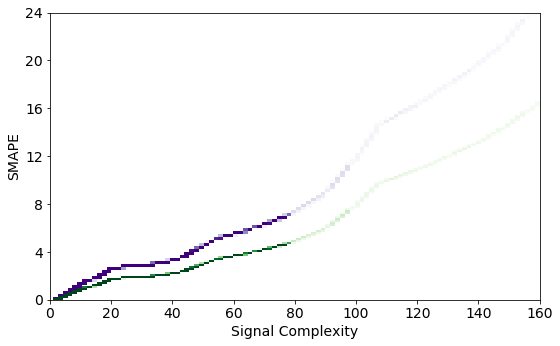

In [189]:
plt.figure(figsize=(8,5))
plt.rcParams.update({'font.size': 14})
ax = plt.axes()
h_2_sim = h2(sc, smape_tv, 100, label='TV-Normalised MSE')
h_2_raw = h2(sc, smape, 100, label='MSE')

rp = h_2_raw.plot("map", lw=0.0, alpha=1,  ax=ax, cmap="Purples",  show_zero=False, cmap_normalize=norm, show_colorbar=False)
sp = h_2_sim.plot("map", lw=0.0, alpha=1,  ax=ax, cmap="Greens",   show_zero=False, cmap_normalize=norm, show_colorbar=False)
plt.xlabel('Signal Complexity')
plt.ylabel('SMAPE')
# plt.title(r'Current $i_d$')
plt.xticks(np.arange(0, 161, 20))
plt.yticks(np.arange(0, 26, 4))
# plt.show()
plt.savefig('tv_vs_mse_sc_smape_torque.pdf', dpi=500, format='pdf', pad_inches=0, bbox_inches = 'tight', transparent=True)